# 모듈 불러오기

#### 기본

In [ ]:
import numpy as np
import pandas as pd
import joblib

In [ ]:
# !conda install numpy 
# !conda install pandas
# !conda install scikit-learn
# !conda install scipy
# !conda install tensorflow
# !conda install matplotlib
# !conda install seaborn
# !pip install ydata-profiling

# !pip install xgboost
# !pip install lightgbm
# !pip install catboost
# !pip install ipywidgets
# !jupyter nbextension enable --py widgetsnbextension
# !pip install hyperopt
# !pip install -U imbalanced-learn
# !pip install missingno
# !pip install shap

#### 전처리

In [ ]:
from sklearn.model_selection import train_test_split

from sklearn import impute
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer

#### 리샘플링

In [ ]:
from imblearn.over_sampling import (
    RandomOverSampler, 
    ADASYN, 
    SMOTE
)
from imblearn.under_sampling import (
    RandomUnderSampler, 
    TomekLinks, 
    CondensedNearestNeighbour, 
    OneSidedSelection, 
    EditedNearestNeighbours, 
    NeighbourhoodCleaningRule
)

#### 분석

In [ ]:
from scipy.stats import skew, kurtosis
from scipy.stats import ttest_ind, f_oneway, pearsonr, chi2_contingency
from ydata_profiling import ProfileReport

#### 회귀

In [ ]:
from sklearn.linear_model import LinearRegression as RL
from sklearn.neighbors import KNeighborsRegressor as KNNR
from sklearn.tree import DecisionTreeRegressor as DTR
from sklearn.svm import SVR
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import RandomForestRegressor as RFR
from xgboost import XGBRegressor as XGBR
from lightgbm import LGBMRegressor as LGBMR
from catboost import CatBoostRegressor as CBR

from lightgbm import plot_importance as lgbm_plot_importance
from xgboost import plot_importance as xgb_plot_importance
from catboost import Pool

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

#### 분류

In [ ]:
from sklearn.linear_model import LogisticRegression as LR
from sklearn.neighbors import KNeighborsClassifier as KNNC
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier as RFC
from xgboost import XGBClassifier as XGBC
from lightgbm import LGBMClassifier as LGBMC
from catboost import CatBoostClassifier as CBC

from sklearn.metrics import confusion_matrix as cmatrix
from sklearn.metrics import classification_report as creport
from sklearn.metrics import recall_score as recall
from sklearn.metrics import accuracy_score as accuracy
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer

#### 교차검증

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from catboost import cv

from hyperopt import hp
from hyperopt import STATUS_OK
from hyperopt import fmin, tpe, Trials

from sklearn.model_selection import (
    StratifiedKFold, # 분류
    KFold, # 회귀
    # GroupKFold, 
    # RepeatedKFold, 
    # StratifiedGroupKFold, 
    # RepeatedStratifiedKFold
)

#### 비즈니스 이해

In [ ]:
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay, partial_dependence

#### 시각화

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.rc('font', family='Malgun Gothic')
sns.set(font="Malgun Gothic",
        rc={"axes.unicode_minus":False}, # 마이너스 부호 깨짐 현상 해결
        style='darkgrid')  

import warnings
warnings.filterwarnings(action='ignore')
%config InlineBackend.figure_format = 'retina'

import shap
tf.compat.v1.disable_v2_behavior() # shap 그래프 tf1 버전 지원 tf2 비활성화

# 데이터 로드

In [ ]:
folder_path = '../분류데이터'

x_train = pd.read_csv(f'{folder_path}/x_train.csv', sep=',', encoding='utf-8')
y_train = pd.read_csv(f'{folder_path}/y_train.csv', sep=',', encoding='utf-8')
x_val = pd.read_csv(f'{folder_path}/x_test.csv', sep=',', encoding='utf-8')
y_val = pd.read_csv(f'{folder_path}/y_test.csv', sep=',', encoding='utf-8')

# RandomizedSearchCV

In [ ]:
model = LGBMC(num_leaves=31, learning_rate=0.1) 

In [ ]:
params = {'max_depth': range(5,20), 
          'n_estimators': range(100, 200, 10),
          'min_child_samples': [20, 22, 24]}
model = RandomizedSearchCV(
                            model,                  # 기본 모델 이름
                            params,                 # 앞에서 선언한 튜닝용 파라미터 변수
                            cv=StratifiedKFold(n_splits=5),                   # k-fold Cross Validation(default=5)
                            n_iter=20,              # Random하게 시도할 횟수(default=10)
                            refit=True,             # 기본값 True
                            scoring=make_scorer(f1_score, average='micro'),     # 평가 방법
                            n_jobs=-1               # cpu 전부 사용
                            )     

In [ ]:
model.fit(x_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=LGBMClassifier(), n_iter=20, n_jobs=-1,
                   param_distributions={'max_depth': range(5, 20),
                                        'min_child_samples': [20, 22, 24],
                                        'n_estimators': range(100, 200, 10)},
                   scoring=make_scorer(f1_score, average=micro))

In [ ]:
model.best_params_, model.best_score_

({'n_estimators': 180, 'min_child_samples': 24, 'max_depth': 8},
 0.9593630515946202)

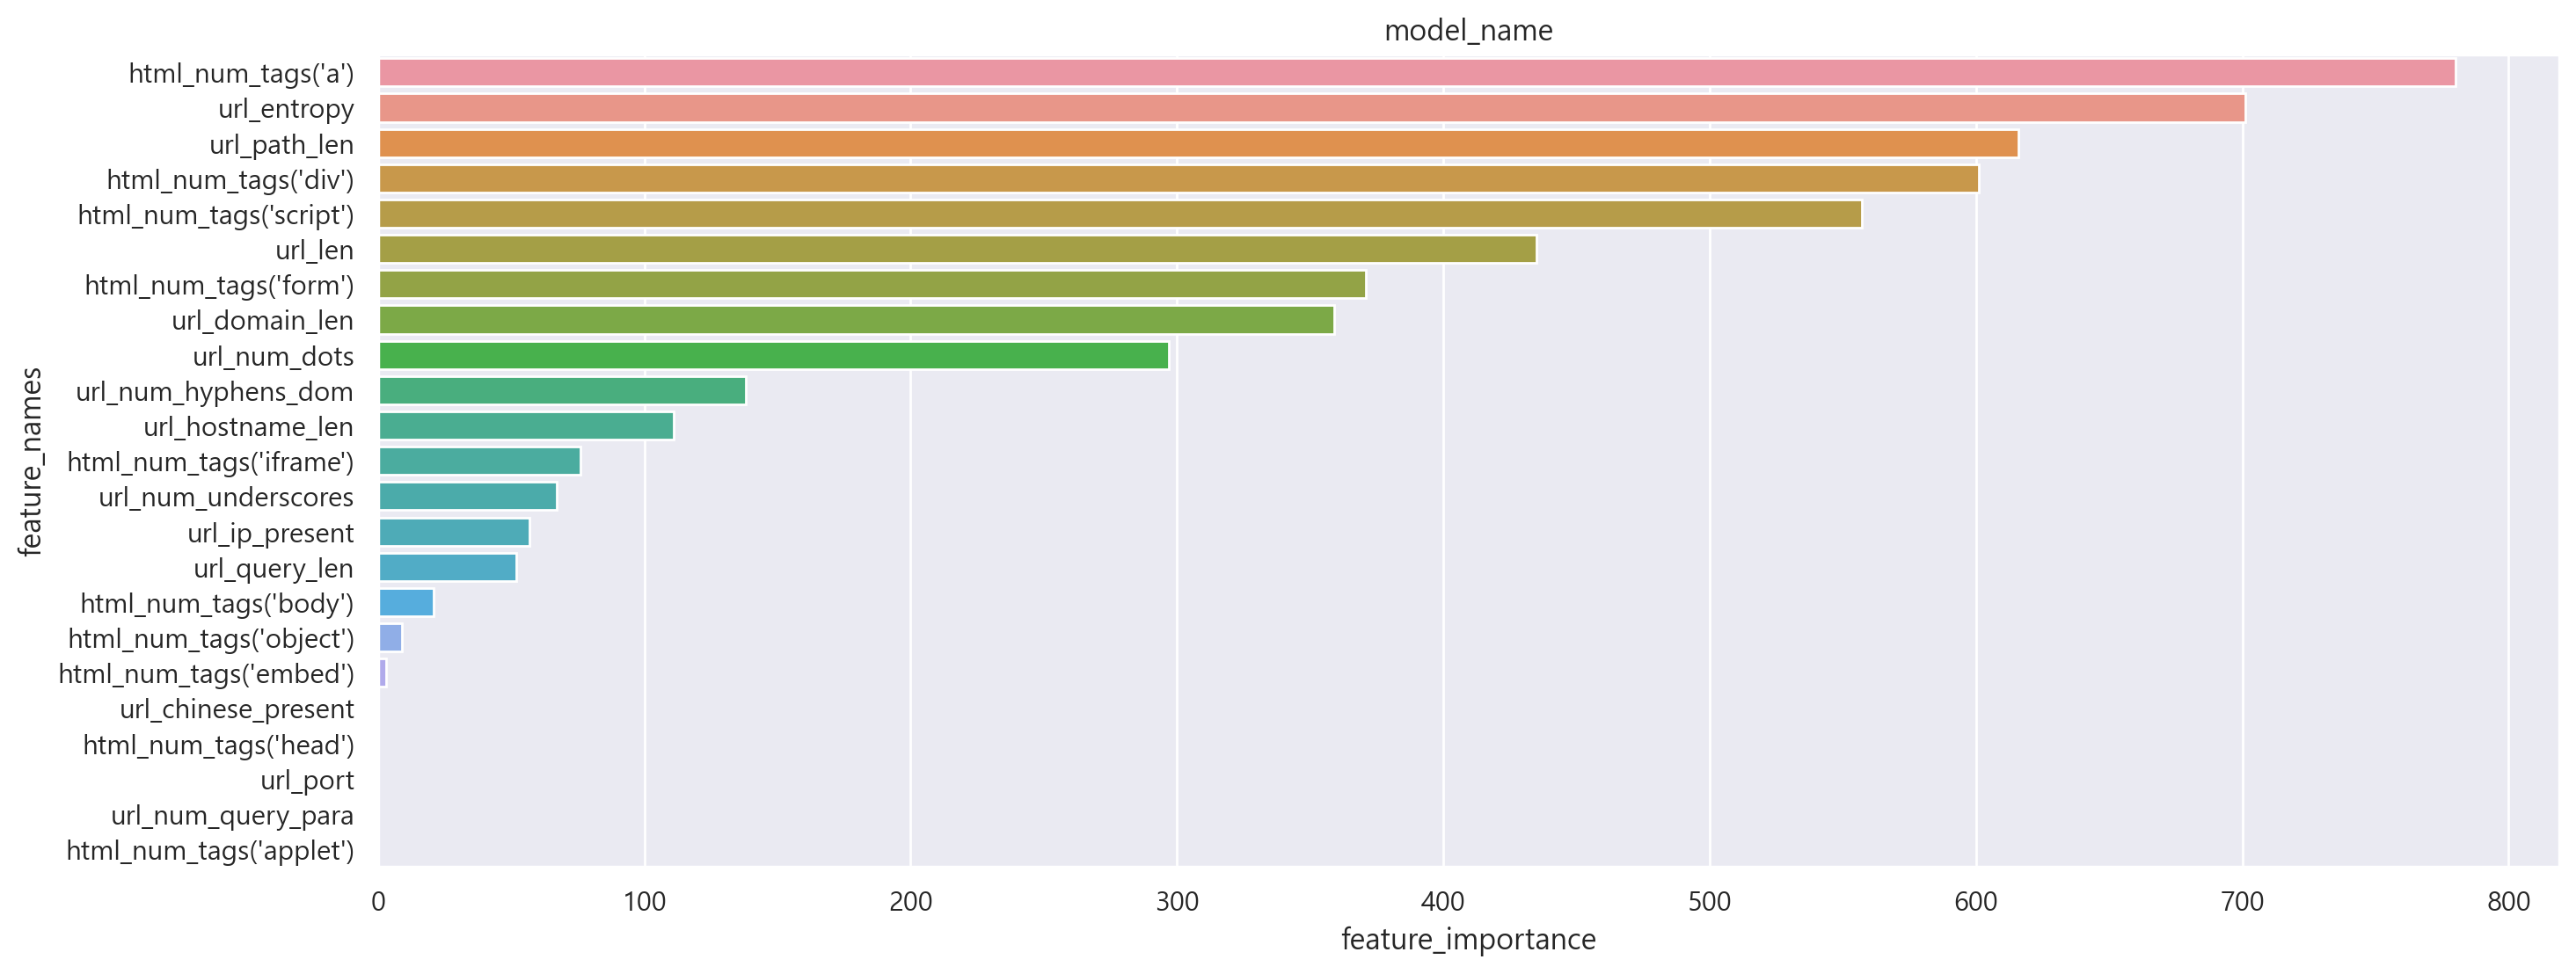

In [ ]:
tmp = pd.DataFrame({'feature_importance': model.best_estimator_.feature_importances_, 'feature_names': list(x_train)}).sort_values('feature_importance', ascending=False)

plt.figure(figsize=(16, 6))
sns.barplot(x='feature_importance', y='feature_names', data = tmp)
plt.title('model_name')
plt.tight_layout()
plt.show()

In [ ]:
# 예측하기
y_pred = model.predict(x_val)

In [ ]:
# 평가하기
print(cmatrix(y_val, y_pred))
print(creport(y_val, y_pred))

[[286  16]
 [ 18 327]]
              precision    recall  f1-score   support

           0       0.94      0.95      0.94       302
           1       0.95      0.95      0.95       345

    accuracy                           0.95       647
   macro avg       0.95      0.95      0.95       647
weighted avg       0.95      0.95      0.95       647

